In [1]:
from light_curves import LightCurve
from exposures import Calexp
from task import Run
import numpy as np

(ra,dec) = (57.59451632893858, -32.481152201226145)/nHTM_ID = 9871854450032 - HTM_level=20 (bounded by a circle of radius ~0.27 arcsec.)


/opt/lsst/software/stack/conda/envs/lsst-scipipe-9.0.0/share/eups/Linux64/daf_butler/g588e17ab67+fac83bd63d/python/lsst/daf/butler/registry/queries/_structs.py:401: FutureWarning: Dimension 'htm20' should no longer be used in data IDs. Use the region 'OVERLAPS' operator in the where clause instead. Will be removed after v28.
  warnings.warn(


Found 145 calexps


/home/karennowo/DP0_microlensing/light_curves.py:107: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.data = pd.concat([self.data, new_data], ignore_index=True)


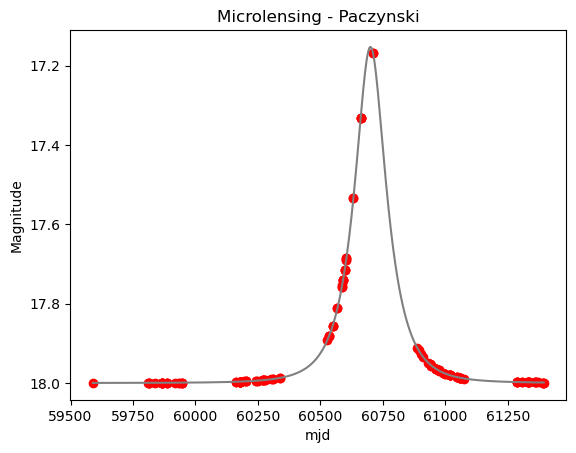

 ------ CALEXP 0 ------
Points injected: 4
[0, 3, 6, 9]


Founded point in source table in 0 iteration/s
Founded point in source table in 0 iteration/s
Founded point in source table in 9 iteration/s
Founded point in source table in 27 iteration/s
ra = 57.59451632893858, dec = -32.481152201226145
Measured  17.994101799126025 0.0029183877292245836
Injected  17.999800399179982
ra = 57.45596185969342, dec = -32.31236131995318
Measured  20.008942550824447 0.009842405430089709
Injected  18.66646706584665
ra = 57.59433361270605, dec = -32.67134286725462
Measured  22.012778522909112 0.04823822776189315
Injected  19.333133732513314
ra = 57.56222369701397, dec = -32.615312420521064
Measured  23.803550588063068 0.23862938491488805
Injected  19.999800399179982
 ------ CALEXP 1 ------
Points injected: 3
[0, 2, 3]


Founded point in source table in 0 iteration/s
Founded point in source table in 0 iteration/s
Founded point in source table in 0 iteration/s
ra = 57.59451632893858, dec = -32.481152201226145
Measured  18.00114260110854 0.0028519741726573617
Injected  17.999526457030296
ra = 57.45596185969342, dec = -32.31236131995318
Measured  19.33093324818412 0.005963072801198803
Injected  18.666193123696964
ra = 57.59433361270605, dec = -32.67134286725462
Measured  20.006258799006464 0.009184940758184016
Injected  19.332859790363628
 ------ CALEXP 2 ------
Points injected: 3
[0, 2, 3]


Founded point in source table in 0 iteration/s
Founded point in source table in 0 iteration/s
Founded point in source table in 0 iteration/s
ra = 57.59451632893858, dec = -32.481152201226145
Measured  17.99848713919169 0.0028028628576488883
Injected  17.999520247493123
ra = 57.45596185969342, dec = -32.31236131995318
Measured  19.33555531185322 0.00573530333910745
Injected  18.66618691415979
ra = 57.59433361270605, dec = -32.67134286725462
Measured  20.00361077044962 0.008631746602035131
Injected  19.332853580826455
 ------ CALEXP 3 ------
Points injected: 3
[0, 4, 7]


In [ ]:
n_points = [10,30,50,70,100]
levels = [20,11,10,9]


for n in n_points:
    for lvl in levels:
        process = Run(name = f"run_{n}pts_{lvl}lvl", htm_level=lvl)
        process.inject_task()
        schema = process.measure_task()
        params = [{"t_0": 60700.5, "t_E": 110, "u_0": 0.5, "m_base": m} for m in np.linspace(18,24,n)]
        process.add_lc(params[0], ra=57.59451632893858, dec=-32.481152201226145, plot = True)
        for p in params[1:]:
            process.add_lc(p, dist=0.2)
        process.log_task("Add and simulate light curves")
        for j, dataId in enumerate(process.calexp_dataIds[:10]):
            print(f" ------ CALEXP {j} ------")
            calexp = Calexp(dataId)
            injected_exp, injected_points = process.inject_calexp(calexp, save_fit=f"calexp_{j}.fit")
            if injected_exp != None:
                sources = process.measure_calexp(injected_exp, schema)
                flux, flux_err = process.find_flux(sources, injected_points, save=dataId)
                for f, ferr, lc in zip(flux, flux_err, process.inj_lc):
                    mag, mag_err = lc.add_mag(f, ferr, dataId, exposure = injected_exp)
                    print(f"ra = {lc.ra}, dec = {lc.dec}")
                    print("Measured ", mag, mag_err)
                    print("Injected ", lc.data["mag_sim"][j])
        process.save_lc()
        process.save_time_log()
        process.time_analysis()

In [14]:
import numpy as np
np.linspace(18,24,5)

array([18. , 19.5, 21. , 22.5, 24. ])